# Visualize the healthy probability distribution across controls and treatments

In the notebook, we create ridge plots for visualizing distributions and platemaps to show the single-cell counts across wells and plates.

## Import libraries

In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridge line plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes

## Create directory for outputs

In [2]:
# Specify the path for the figures directory
figures_dir <- "./figures"
# Specify the path for the plate maps directory
platemaps_dir <- file.path(figures_dir, "platemaps")

# Create the figures directory if it doesn't exist
if (!dir.exists(figures_dir)) {
  dir.create(figures_dir, recursive = TRUE)
}

# Create the plate maps directory if it doesn't exist
if (!dir.exists(platemaps_dir)) {
  dir.create(platemaps_dir, recursive = TRUE)
}

## Load in the combined probabilities per batch

In [3]:
# load in the probabilities
combined_probabilities_path <- file.path(
    paste0(
        "./prob_data/combined_batch_1_predicted_proba.csv"
    )
)
# read in the data from the parquet file
combined_probabilities_df <- read.csv(
    combined_probabilities_path
)
dim(combined_probabilities_df)
head(combined_probabilities_df,2)

[1] 109192     23

,Failing_probas,Healthy_probas,predicted_label,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,⋯,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,model_type
,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,0.6360041,0.3639959,Failing,B,2,7,Healthy,,DMSO,855.5996,⋯,9,2,localhost240928120001,B02,1,1,6,6,f04,shuffled
2,0.5030088,0.4969912,Failing,B,2,7,Healthy,,DMSO,613.9370,⋯,4,3,localhost240928120001,B02,1,1,3,3,f10,shuffled


## Load in pathways file and merge together the pathway to each single-cell based on batch

In [4]:
# Extract the batch information from the filename
# Assuming the filename format is always "combined_batch_X_predicted_proba.csv"
batch_var <- sub("combined_batch_(\\d+)_predicted_proba\\.csv", "batch_\\1", "combined_batch_1_predicted_proba.csv")

# Extract the plate number from the batch variable (e.g., extract "1" from "batch_1")
plate_number <- sub("batch_", "", batch_var)

# Load in the pathways platemap info
pathway_map <- read.csv("../metadata/pathways_platemap.csv")

# Filter for rows where Plate matches the extracted plate number from batch variable
filtered_pathway_map <- pathway_map %>%
  filter(Plate == paste0("Plate_", plate_number)) %>%
  mutate(batch = batch_var)  # Add a new column to denote the current batch

# Merge the filtered pathway data with combined_probabilities_df
annotated_combined_probabilities <- combined_probabilities_df %>%
  left_join(filtered_pathway_map, by = c("Metadata_Well" = "Well"))

# Check the merged data
head(annotated_combined_probabilities)

,Failing_probas,Healthy_probas,predicted_label,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,⋯,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,model_type,UCD.ID,Plate,Cell.Type,Pathway,batch
,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,0.6360041,0.3639959,Failing,B,2,7,Healthy,,DMSO,855.5996,⋯,1,6,6,f04,shuffled,DMSO,Plate_1,healthy,,batch_1
2,0.5030088,0.4969912,Failing,B,2,7,Healthy,,DMSO,613.9370,⋯,1,3,3,f10,shuffled,DMSO,Plate_1,healthy,,batch_1
3,0.6508621,0.3491379,Failing,B,2,7,Healthy,,DMSO,916.3797,⋯,1,3,3,f14,shuffled,DMSO,Plate_1,healthy,,batch_1
4,0.3863711,0.6136289,Healthy,B,2,7,Healthy,,DMSO,530.4115,⋯,1,3,3,f18,shuffled,DMSO,Plate_1,healthy,,batch_1
5,0.7344571,0.2655429,Failing,B,2,7,Healthy,,DMSO,958.3017,⋯,1,4,4,f00,shuffled,DMSO,Plate_1,healthy,,batch_1
6,0.6460051,0.3539949,Failing,B,2,7,Healthy,,DMSO,261.3994,⋯,1,4,4,f20,shuffled,DMSO,Plate_1,healthy,,batch_1


## Print out the number of control cells (DMSO) across healthy and failing cell type in total and across plate

In [5]:
# Filter for Metadata_treatment == "DMSO", then group by Metadata_cell_type and count
counts_df <- combined_probabilities_df %>%
  filter(Metadata_treatment == "DMSO") %>%  # Filter for DMSO treatment
  group_by(Metadata_cell_type) %>%
  summarise(count = n(), .groups = "drop") %>%  # Drop grouping after summarise
  ungroup()

# Print counts_df
head(counts_df)

# Now, split by Metadata_Plate and Metadata_cell_type
counts_by_plate_df <- combined_probabilities_df %>%
  filter(Metadata_treatment == "DMSO") %>%  # Filter for DMSO treatment
  group_by(Metadata_Plate, Metadata_cell_type) %>%
  summarise(count = n(), .groups = "drop") %>%  # Drop grouping after summarise
  ungroup()

# Print counts_by_plate_df
counts_by_plate_df

Metadata_cell_type,count
<chr>,<int>
Failing,9830
Healthy,3440


Metadata_Plate,Metadata_cell_type,count
<chr>,<chr>,<int>
localhost240926150001,Failing,2790
localhost240926150001,Healthy,1254
localhost240927060001,Failing,2448
localhost240927060001,Healthy,604
localhost240927120001,Failing,2262
localhost240927120001,Healthy,766
localhost240928120001,Failing,2330
localhost240928120001,Healthy,816


## Print of total of correct versus incorrect prediction across cell type in total

In [6]:
# Filter for Metadata_treatment == "DMSO", group by Metadata_cell_type and predicted_label, and count
counts_df <- combined_probabilities_df %>%
  filter(Metadata_treatment == "DMSO") %>%  # Filter for DMSO treatment
  group_by(Metadata_cell_type, predicted_label) %>%
  summarise(count = n(), .groups = "drop") %>%  # Drop grouping after summarise
  ungroup()

head(counts_df)

Metadata_cell_type,predicted_label,count
<chr>,<chr>,<int>
Failing,Failing,2653
Failing,Healthy,7177
Healthy,Failing,792
Healthy,Healthy,2648


## Generate ridge plot for DMSO controls only facet by plate and model type (final or shuffled)

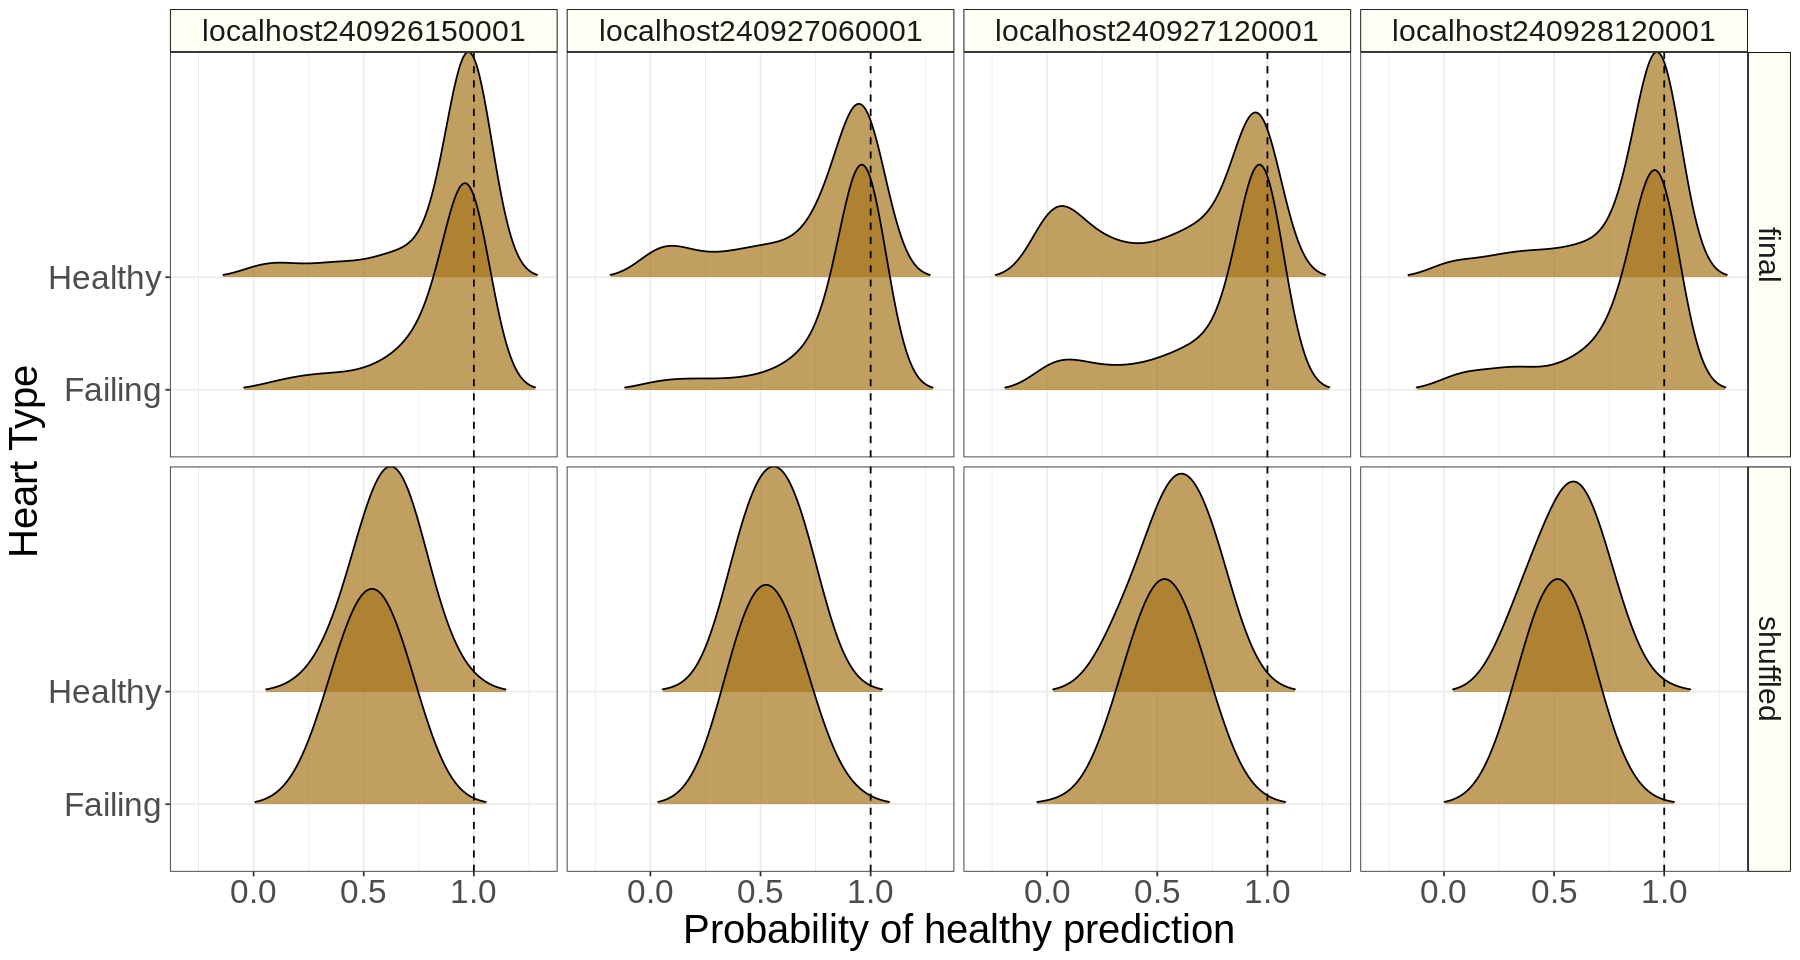

In [7]:
# Filter to only include DMSO treatment
filtered_df <- combined_probabilities_df %>% filter(Metadata_treatment == "DMSO")

height <- 8
width <- 15
options(repr.plot.width = width, repr.plot.height = height)

ridge_plot_healthy <- ggplot(filtered_df, aes(x = Healthy_probas, y = Metadata_cell_type, fill = Metadata_treatment)) +
  geom_density_ridges(aes(fill = Metadata_treatment), alpha = 0.7, scale = 2, rel_min_height = 0.01, bandwidth = 0.1) +
  scale_fill_manual(values = c("DMSO" = brewer.pal(8, "Dark2")[7])) +  # Only include DMSO color
  geom_vline(xintercept = 1, linetype = "dashed", color = "black") +
  scale_x_continuous(breaks = seq(0, 1, 0.5)) +
  facet_grid(model_type ~ Metadata_Plate, scales = "free_y") +  # Facet by Metadata_Plate instead of Metadata_treatment
  labs(x = "Probability of healthy prediction", y = "Heart Type") +  # Update x-axis label
  theme_bw() +
  theme(
    legend.position = "none",
    axis.text = element_text(size = 20),
    axis.text.x = element_text(size = 20),
    axis.title = element_text(size = 24),
    strip.text = element_text(size = 18),
    strip.background = element_rect(
      colour = "black",
      fill = "#fdfff4"
    )
  )

# Save figure
ggsave(paste0("./figures/", batch_var, "_DMSO_controls_ridge_plot.png"), ridge_plot_healthy, height = height, width = width, dpi = 500)

ridge_plot_healthy

## Generate ridge plot for only treatments facet by plate and colored by pathway

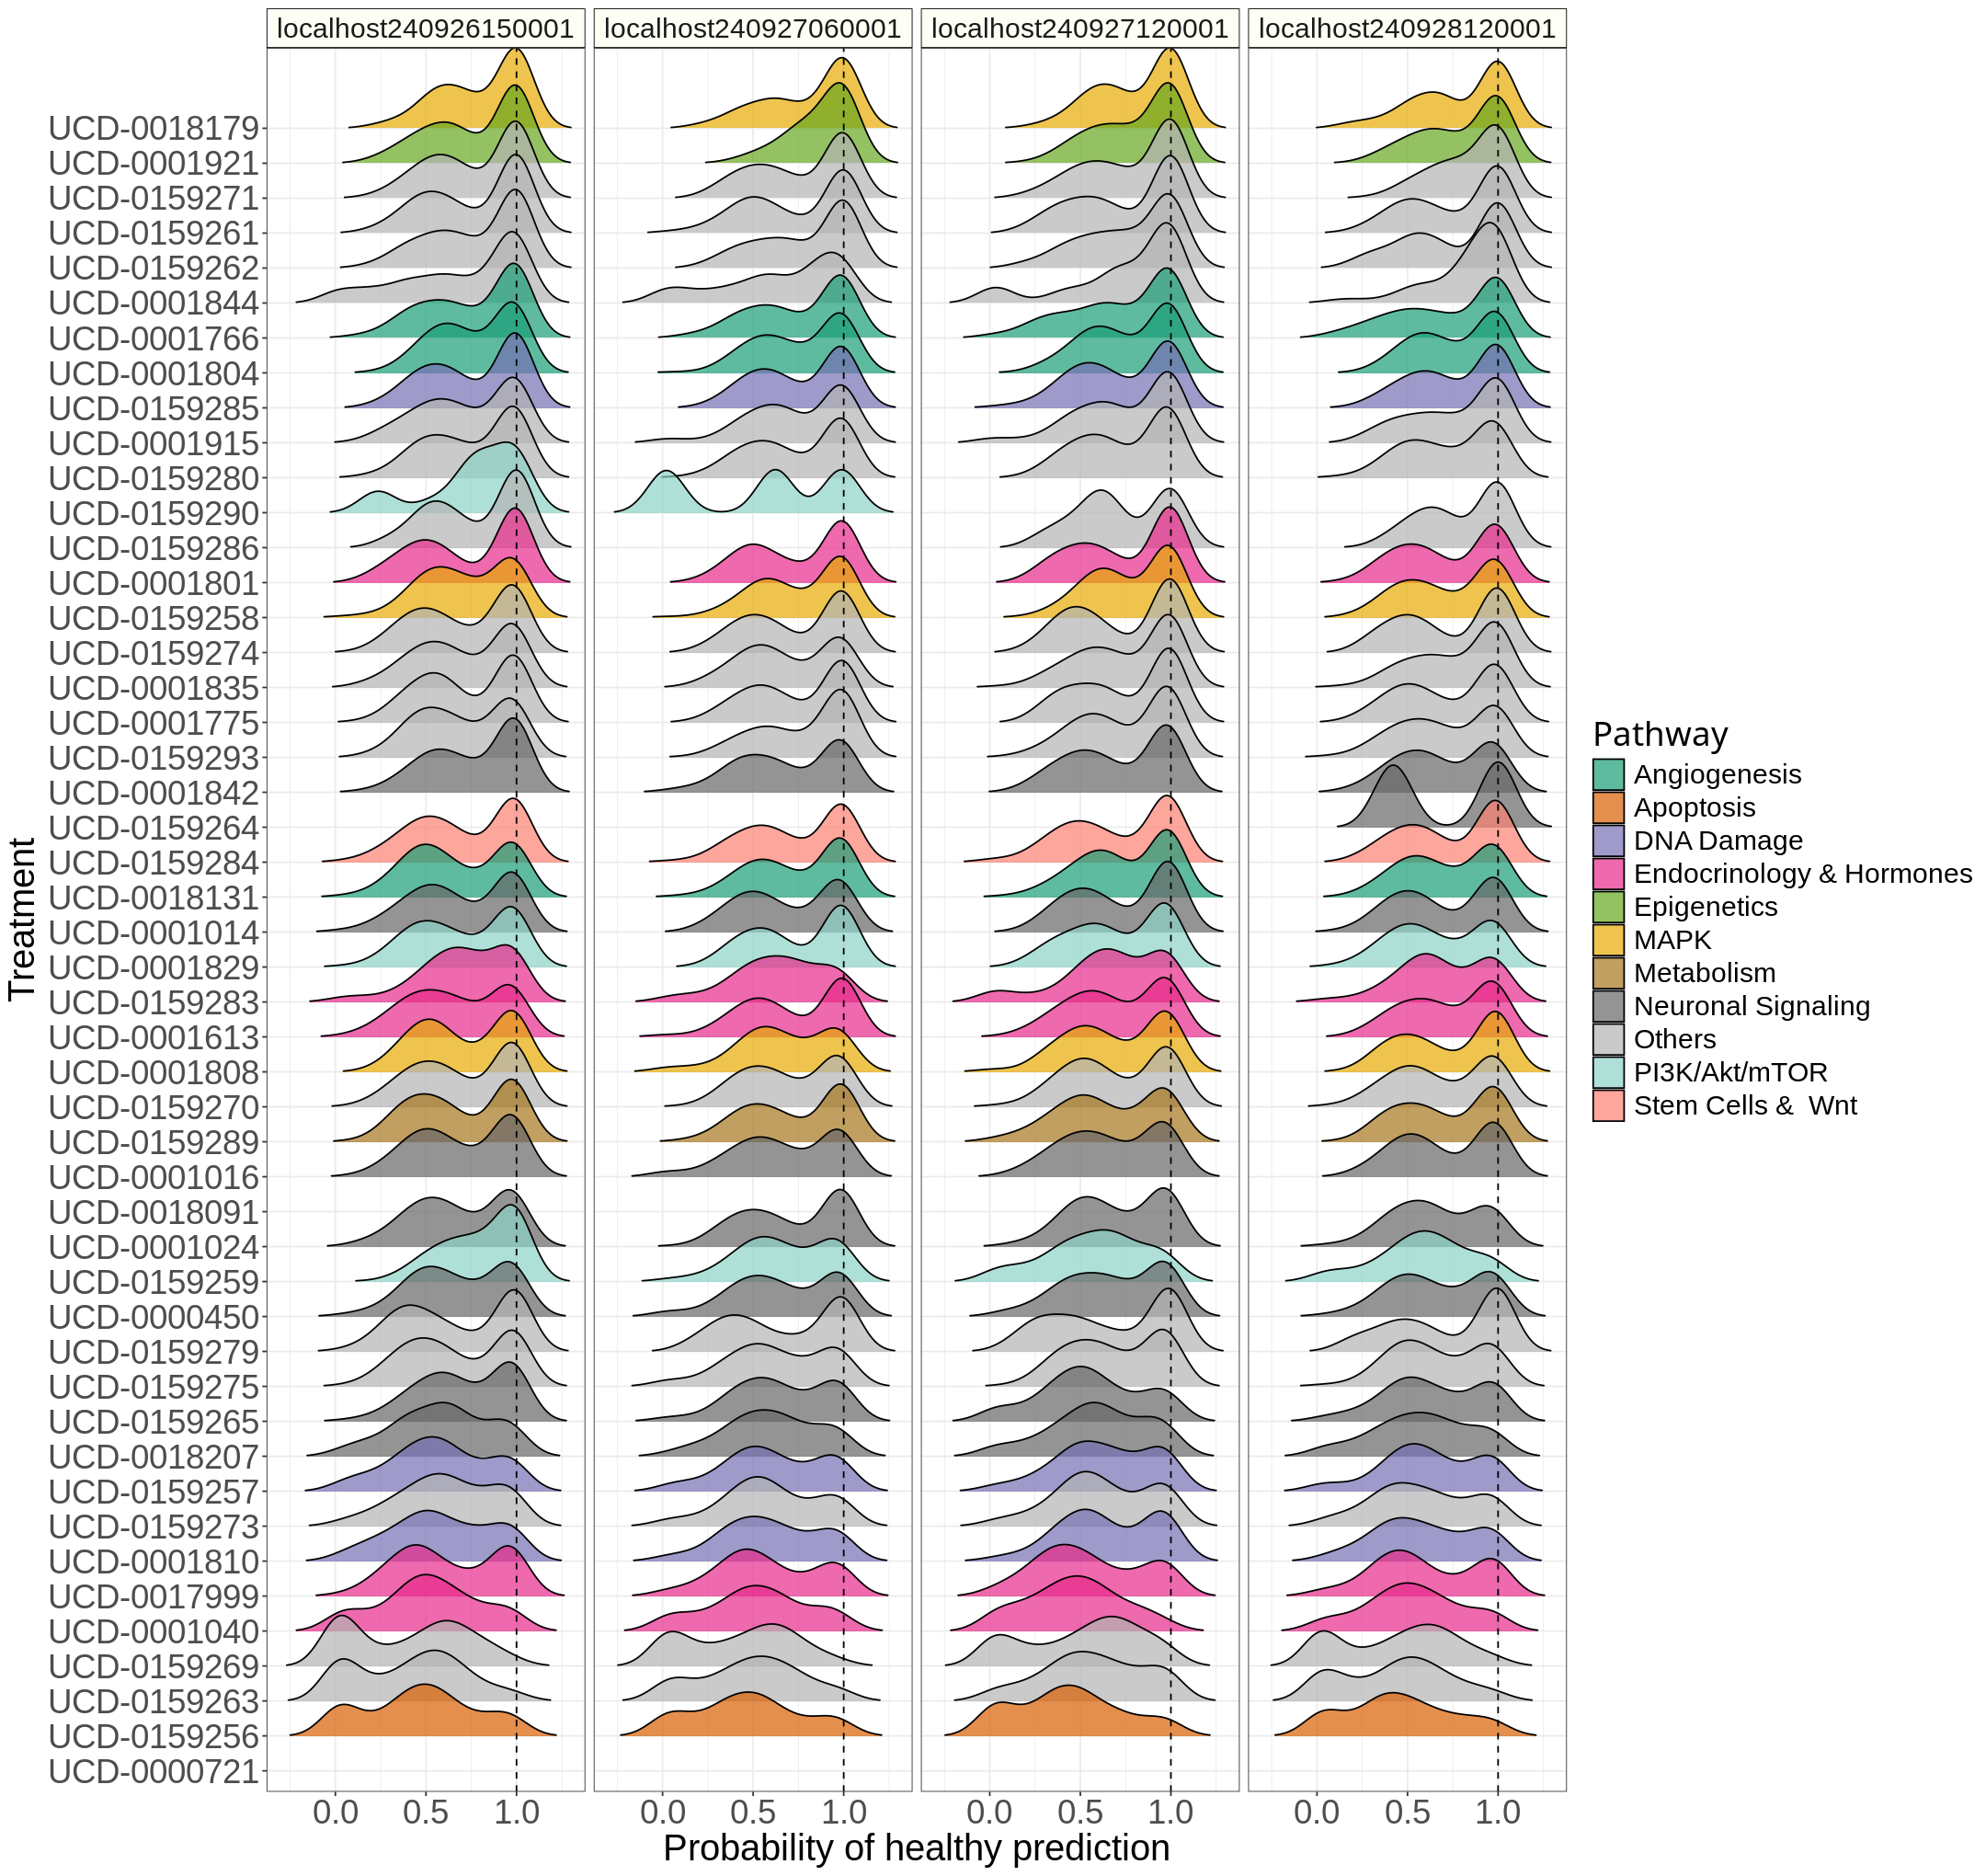

In [8]:
# Custom color palette inspired by Dark2
custom_palette <- c(
  "#1b9e77",  # Dark2 color 1
  "#d95f02",  # Dark2 color 2
  "#7570b3",  # Dark2 color 3
  "#e7298a",  # Dark2 color 4
  "#66a61e",  # Dark2 color 5
  "#e6ab02",  # Dark2 color 6
  "#a6761d",  # Dark2 color 7
  "#666666",  # Dark2 color 8
  "#b3b3b3",  # Light gray (alternative)
  "#8dd3c7",  # Teal (alternative)
  "#fb8072"   # Light coral (alternative)
)

# Filter out DMSO treatment
filtered_df <- annotated_combined_probabilities %>% filter(Metadata_treatment != "DMSO")

# Step 1: Calculate the median Healthy_probas for each treatment (you can use mean instead)
treatment_order <- filtered_df %>%
  group_by(Metadata_treatment) %>%
  summarise(median_healthy_proba = median(Healthy_probas)) %>%
  arrange(desc(median_healthy_proba))  # Sort in descending order of median

# Step 2: Reorder the 'Metadata_treatment' factor levels in reverse order for top-to-bottom plotting
filtered_df <- filtered_df %>%
  mutate(Metadata_treatment = factor(Metadata_treatment, levels = rev(treatment_order$Metadata_treatment)))

# Step 3: Create the ridge plot with reordered treatments
height <- 17
width <- 18
options(repr.plot.width = width, repr.plot.height = height)

# Create a ridge plot excluding DMSO and using all other treatments on the y-axis
ridge_plot_non_DMSO <- ggplot(filtered_df, aes(x = Healthy_probas, y = Metadata_treatment, fill = Pathway)) +
  geom_density_ridges(alpha = 0.7, scale = 2.25, rel_min_height = 0.01, bandwidth = 0.1) +  # Ridges colored by Pathway
  geom_vline(xintercept = 1, linetype = "dashed", color = "black") +
  scale_x_continuous(breaks = seq(0, 1, 0.5)) +
  labs(x = "Probability of healthy prediction", y = "Treatment") +  # Update axis labels
  scale_fill_manual(values = custom_palette) +  # Use the custom color palette
  theme_bw() +
  theme(
    legend.position = "right",  # Position the legend on the right
    legend.title = element_text("Pathway", size = 22),
    axis.text = element_text(size = 22),
    axis.text.x = element_text(size = 22),
    axis.title = element_text(size = 24),
    strip.text = element_text(size = 18),
    strip.background = element_rect(
      colour = "black",
      fill = "#fdfff4"
    ),
    legend.text = element_text(size = 18),  # Adjust legend text size if needed
    legend.key.size = unit(1.5, "lines")  # Adjust the size of the legend keys
  ) +
  facet_wrap(~ Metadata_Plate, ncol = 4)  # Facet by Metadata_Plate, set ncol to a value > 1 for horizontal layout

# Save figure
ggsave(paste0("./figures/", batch_var, "_treatments_only_ridge_plot.png"), ridge_plot_non_DMSO, height = height, width = width, dpi = 500)

ridge_plot_non_DMSO


## Generate platemaps using single-cell counts

### Calculate single cell counts per well and plate based on probability df

In [9]:
# Assuming combined_probabilities_df is your dataframe
cell_counts_df <- combined_probabilities_df %>%
  group_by(Metadata_Plate, Metadata_Well) %>%
  summarise(Single_Cell_Count = n(), .groups = 'drop')  # Count cells per well

# View the resulting dataframe
dim(cell_counts_df)
head(cell_counts_df)


[1] 214   3

Metadata_Plate,Metadata_Well,Single_Cell_Count
<chr>,<chr>,<int>
localhost240926150001,B02,468
localhost240926150001,B03,500
localhost240926150001,B04,464
localhost240926150001,B05,118
localhost240926150001,B06,320
localhost240926150001,B07,480


### Combine single-cell count with pathway df which includes wells that would have no single cells

In [10]:
# Select only the Well and Pathway from filtered_pathway_map
pathway_map_selected <- filtered_pathway_map %>%
  select(Well, Pathway)  # Ensure the column name is Well for merging

# Create a dataframe per plate
plate_names <- unique(cell_counts_df$Metadata_Plate)  # Get unique plate names

# List to store dataframes for each plate
plate_dataframes <- list()

for (plate in plate_names) {
  # Filter cell counts for the current plate
  plate_cell_counts <- cell_counts_df %>%
    filter(Metadata_Plate == plate)
  
  # Merge the cell counts with the selected pathway map
  merged_df <- pathway_map_selected %>%
    left_join(plate_cell_counts, by = c("Well" = "Metadata_Well"))  # Specify the join condition

    # Set NA in Single_Cell_Count to 0
  merged_df <- merged_df %>%
    mutate(Single_Cell_Count = ifelse(is.na(Single_Cell_Count), 0, Single_Cell_Count))

    
  # Fill NA in Metadata_Plate with the current plate name
  merged_df <- merged_df %>%
    mutate(Metadata_Plate = ifelse(is.na(Metadata_Plate), plate, Metadata_Plate))

  # Add plate single-cell count info to be accessed for plotting
  plate_dataframes[[plate]] <- merged_df
}


### Create platemap per plate using single-cell count as color label

In [11]:
# Loop through each plate dataframe and generate the platemap
for (plate_name in names(plate_dataframes)) {
  
  # Get the dataframe for the current plate
  plate_df <- plate_dataframes[[plate_name]]
  
  # Generate the plate map using platetools::raw_map
  platemap <- platetools::raw_map(
    data = plate_df$Single_Cell_Count,  # The single-cell counts
    well = plate_df$Well,      # The well information
    plate = 96,                         # Assuming 96-well plate
    size = 8                           # Adjust as necessary
  ) +
    ggtitle(paste("Platemap of single-cell count per well in plate\n", plate_name, "after single-cell QC")) +
    theme(plot.title = element_text(size = 10, face = "bold")) +
    scale_fill_gradient(
      name = "Single-cell\ncount", 
      low = "white", high = "red", 
      limits = c(0, max(plate_df$Single_Cell_Count, na.rm = TRUE)),
  ) +
    theme(
      plot.title = element_text(size = 10, face = "bold"),
      legend.title = element_text(size = 12),  # Adjust the legend title size here
      legend.text = element_text(size = 12)    # Optionally adjust legend text size
  )
  
  # Save the plot with the required naming convention
  ggsave(
    filename = paste0(platemaps_dir, "/", batch_var, "_", plate_name, "_sc_counts.png"),
    plot = platemap,
    height = 4,
    width = 6,
    dpi = 500
  )
}